In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
from pathlib import Path
import re
import warnings
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
sys.path.append('src')
# from src.non_snow_retrievals import canopy_permittivity, vegetation_phase
from src.swe_retrievals import *

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter('ignore', SettingWithCopyWarning)


In [2]:
# test = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/compiled/1000_am.csv', parse_dates=True, index_col=0)
test = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
test

,ecoregion,station_name,station_id,lat,lon,sand,clay,sturm,landfire,canopy_height,state
0,North Cascades,Paradise,679,46.78266,-121.74767,748,19,3,112,12.0,WA
1,Cascades,Clackamas Lake,398,45.09658,-121.75443,524,164,4,304,0.4,OR
2,Eastern Cascades,Annie Springs,1000,42.87007,-122.16518,705,24,3,31,0.0,OR
3,Sierra Nevada,Virginia Lakes Rdg,846,38.07298,-119.23433,596,81,6,115,15.0,CA
4,Blue Mountains,Tipton,821,44.65567,-118.42617,386,95,6,119,19.0,OR
5,Northern Basin and Range,Silvies,759,42.75333,-118.68785,397,224,5,208,0.8,OR
6,Central Basin and Range,Corral Canyon,417,40.27551,-115.54017,430,190,5,113,13.0,NV
7,Columbia Mtns/Northern Rockies,Sunset,803,47.55545,-115.82422,304,110,6,120,20.0,ID
8,Idaho Batholith,Galena Summit,490,43.87497,-114.71363,497,126,2,205,0.5,ID
9,Middle Rockies,Lewis Lake Divide,577,44.20862,-110.66628,462,118,5,207,0.7,WY


## Figure 1 - SWE curves and error comparison

In [26]:
def plot_swe_curves(station_id: int, wateryear: int, time: str = 'am', ax1=None,
                    ax2=None, plot_type: str = 'total_error', return_data: bool = True):
    """
    679	Paradise
    398	Clackamas Lake
    1000	Annie Springs
    846	Virginia Lakes Rdg
    821	Tipton
    759	Silvies
    417	Corral Canyon
    803	Sunset
    490	Galena Summit
    577	Lewis Lake Divide
    828	Trial Lake
    935	Jackwhacker Gulch
    708	Quemazon
    """
    sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
    site = sites.loc[sites['station_id']==station_id]
    df = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_{time}.csv',
                     index_col=0, parse_dates=True)
    # Subset for water year
    df['wateryear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in df.index]
    df = df.loc[df['wateryear']==wateryear]
    df = df.loc[:f'{wateryear}-07-01']
    
    # Calculate errors from pre-compiled data
    # Soil moisture
    df['soil_error'] = calc_soil_moisture_error(sand=site['sand']/10, 
                                                clay=site['clay']/10, 
                                                sm_series=df['soil_moisture_pct']/100)
    # Veg permittivity changes
    df['veg_error'] = calc_veg_permittivity_error(canopy_height=site['canopy_height'].values[0], 
                                                  temperature_series=df['airtemp_C'])
    # Dry atmosphere
    df['dry_atmo_error'] = calc_dry_atmo_error(pressure_series=df['surf_pres'])
    # Wet atmosphere
    df['wet_atmo_error'] = calc_wet_atmo_error(pw_series=df['precip_water']/1000)
    # Ionosphere
    df['ion_error'] = calc_ionosphere_error(tec_series=df['ion_tec'])
    # Surface deformation
    
    # Total error
    df['total_error'] = df[['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']].sum(axis=1,min_count=1)
    df['non_ion_error'] = df[['soil_error','veg_error','dry_atmo_error','wet_atmo_error']].sum(axis=1,min_count=1)
    
    
    
    if plot_type == 'total_error':
        # Total error plot
        df['swe_m'].plot(ax=ax1, label='SNOTEL')
#         (df['total_error'] + df['swe_m']).plot(ax=ax1, label='SNOTEL + all errors')
        (df['non_ion_error'] + df['swe_m']).plot(ax=ax1, label='SNOTEL + all except ion')
        
        ax1.set_title(f'{site["station_name"].values[0]} {wateryear}')
        ax1.set_xlabel('')
        ax1.set_ylabel('SWE [m]')
        ax1.legend()
        
        # Error components
        percent_error = pd.DataFrame(index=df.index)
        for c in ['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']:
            percent_error[c] = df[c]/df['swe_m']*100
            
        percent_error.loc[df['swe_m'] < 0.1] = np.nan
        percent_error['soil_error'].plot(ax=ax2, label='Soil moisture')
        percent_error['veg_error'].plot(ax=ax2, label='Veg permittivity')
        percent_error['dry_atmo_error'].plot(ax=ax2, label='Dry atmosphere')
        percent_error['wet_atmo_error'].plot(ax=ax2, label='Wet atmosphere')
#         percent_error['ion_error'].plot(ax=ax2, label='Ionosphere')
#         ax.set_title(f'{site["station_name"].values[0]} {wateryear}')
        ax2.set_xlabel('')
        ax2.set_xlim(ax1.get_xlim())
#         ax2.set_ylim([-100,50])
        ax2.set_ylabel('SWE error [% of SWE on the ground]')
        ax2.legend()
        
    elif plot_type == 'individual':
        if ax1 is None:
            fig, ax1 = plt.subplots(figsize=(6,6))
        
        df['swe_m'].plot(ax=ax1, label='SNOTEL')
        (df['soil_error'] + df['swe_m']).plot(ax=ax1, label='Soil moisture')
        (df['veg_error'] + df['swe_m']).plot(ax=ax1, label='Veg permittivity')
        (df['dry_atmo_error'] + df['swe_m']).plot(ax=ax1, label='Dry atmosphere')
        (df['wet_atmo_error'] + df['swe_m']).plot(ax=ax1, label='Wet atmosphere')
        (df['ion_error'] + df['swe_m']).plot(ax=ax1, label='Ionosphere')
    
        ax1.set_title(f'{site["station_name"].values[0]} {wateryear}')
        ax1.set_xlabel('')
        ax1.set_ylabel('SWE [m]')
        ax1.legend()
    
    if return_data:
        return df


# for axx in ax.flatten():
#     axx.set_ylim([-0.02, 1.02]

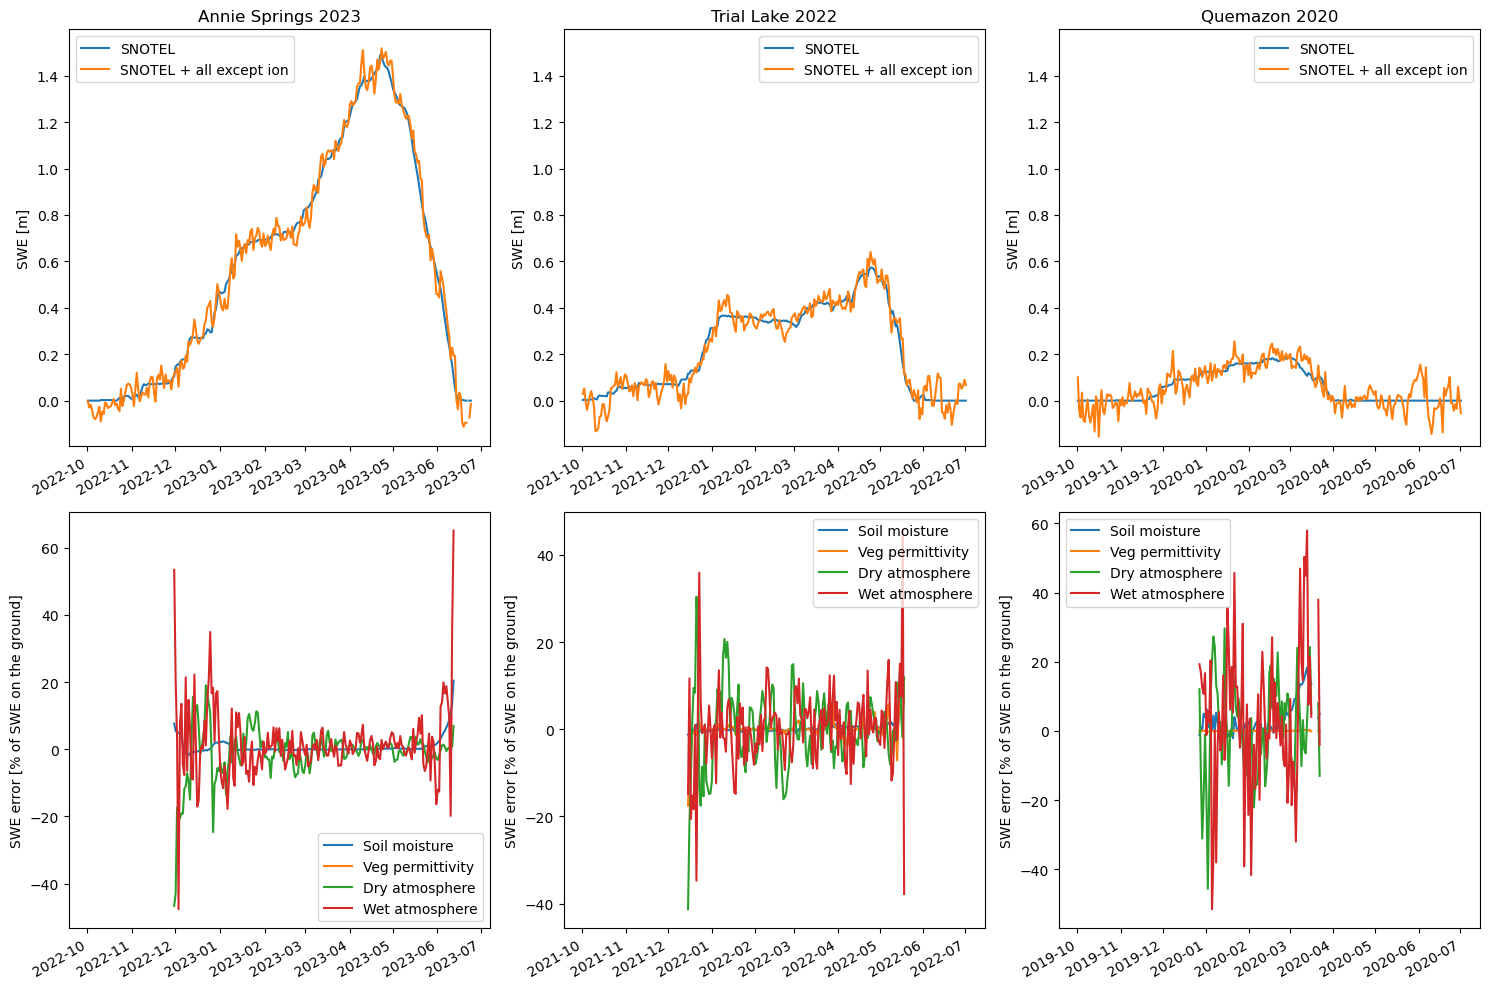

In [27]:
station_id = 1000
wateryear = 2023

sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
site = sites.loc[sites['station_id']==station_id]
# df = plot_swe_curves(station_id=station_id, wateryear=wateryear)

# 1000 2023

fig, ax = plt.subplots(2, 3, figsize=(15,10))
test = plot_swe_curves(station_id=1000, wateryear=2023, ax1=ax[0,0], ax2=ax[1,0], return_data=True)
plot_swe_curves(station_id=828, wateryear=2022, ax1=ax[0,1], ax2=ax[1,1], return_data=False)
plot_swe_curves(station_id=708, wateryear=2020, ax1=ax[0,2], ax2=ax[1,2], return_data=False)
ymin = min([ax.get_ylim()[0] for ax in ax[0]])
ymax = max([ax.get_ylim()[1] for ax in ax[0]])
for axx in ax[0]:
    axx.set_ylim([ymin, ymax])
plt.tight_layout()
plt.show()

# fig, ax = plt.subplots(2, 5, figsize=(20,8))

# for i, year in enumerate(range(2017,2026)):
#     plot_swe_curves(station_id=708, wateryear=year, plot_type='individual', ax1=ax.flatten()[i], return_data=False)
    
# plt.tight_layout()

In [28]:
fig.savefig('fig1_all_but_ion.png', dpi=300)

# percent_error = test[['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']]/test['swe_m']*100
# percent_error#.loc[df['swe_m'] < 0.1] = np.nan

In [9]:
mores_files = sorted(glob('../data_sandbox/swe_errors/snotel/hourly/637*.csv'))
mores = pd.read_csv(mores_files[0], header=1, parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct)  (silt)':'sm_2cm'})
mores.index = mores['Date_Time']
mores.drop(columns=['Date_Time', 'Site Id'], inplace=True)

for f in mores_files[1:]:
    df_tmp = pd.read_csv(f, header=1, parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct)  (silt)':'sm_2cm'})
    df_tmp.index = df_tmp['Date_Time']
    df_tmp.drop(columns=['Date_Time', 'Site Id'], inplace=True)
    mores = pd.concat([mores, df_tmp])

mores['WaterYear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in mores.index]
mores = mores[[c for c in mores.columns if 'Unnamed' not in c]]


chena_files = sorted(glob('../data_sandbox/swe_errors/snotel/hourly/947*.csv'))
chena = pd.read_csv(chena_files[0], header=1, parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct) ':'sm_2cm'})
chena.index = chena['Date_Time']
chena.drop(columns=['Date_Time', 'Site Id'], inplace=True)

for f in chena_files[1:]:
    df_tmp = pd.read_csv(f, header=1, parse_dates=[[1,2]], na_values=['-99.9']).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct) ':'sm_2cm'})
    df_tmp.index = df_tmp['Date_Time']
    df_tmp.drop(columns=['Date_Time', 'Site Id'], inplace=True)
    chena = pd.concat([chena, df_tmp])

chena['WaterYear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in chena.index]
chena = chena[[c for c in chena.columns if 'Unnamed' not in c]]



for df in [mores, chena]:
    df['dowy'] = [(r[0] - pd.to_datetime(f'{int(r[1]["WaterYear"])-1}-10-01')) for r in df.iterrows()] # type: ignore
    df['dowy'] = df['dowy'].dt.days + 1

    
    


Text(0.5, 1.0, 'Mores Creek Summit')

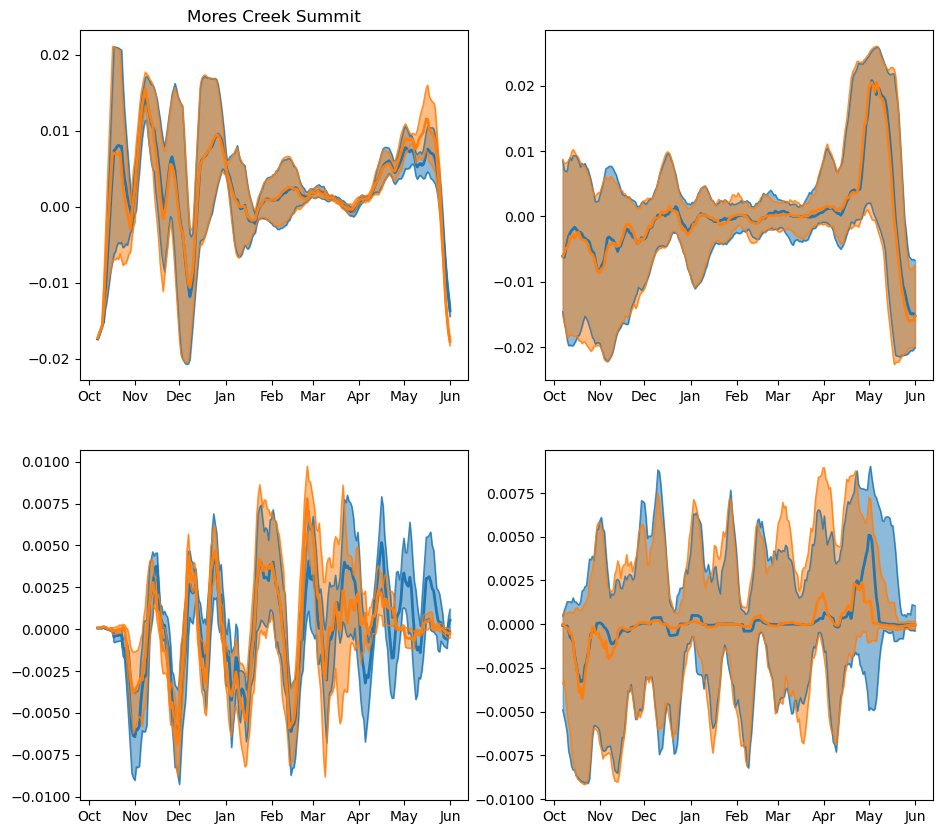

In [59]:
mores_sand = 45.1
mores_clay = 14.4

chena_sand = 31.2
chena_clay = 11.8

mores_6am = mores.loc[mores.index.hour==6]
mores_6pm = mores.loc[mores.index.hour==18]
mores_6am['soil_error'] = calc_soil_moisture_error(mores_sand, mores_clay, mores_6am['sm_2cm']/100)
mores_6pm['soil_error'] = calc_soil_moisture_error(mores_sand, mores_clay, mores_6pm['sm_2cm']/100)

chena_6am = chena.loc[chena.index.hour==6]
chena_6pm = chena.loc[chena.index.hour==18]
chena_6am['soil_error'] = calc_soil_moisture_error(chena_sand, chena_clay, chena_6am['sm_2cm']/100)
chena_6pm['soil_error'] = calc_soil_moisture_error(chena_sand, chena_clay, chena_6pm['sm_2cm']/100)

mores_veg_height = 6
mores_6am['veg_error'] = calc_veg_permittivity_error(canopy_height=mores_veg_height, temperature_series=mores_6am['TAVG.H-1 (degC) '])
mores_6pm['veg_error'] = calc_veg_permittivity_error(canopy_height=mores_veg_height, temperature_series=mores_6pm['TAVG.H-1 (degC) '])


chena_veg_height = 5
chena_6am['veg_error'] = calc_veg_permittivity_error(canopy_height=chena_veg_height, temperature_series=chena_6am['TOBS.I-1 (degC) '])
chena_6pm['veg_error'] = calc_veg_permittivity_error(canopy_height=chena_veg_height, temperature_series=chena_6pm['TOBS.I-1 (degC) '])



mores6am_gb = mores_6am.loc[mores['dowy']<=244].groupby('dowy')
mores6pm_gb = mores_6pm.loc[mores['dowy']<=244].groupby('dowy')
chena6am_gb = chena_6am.loc[chena['dowy']<=244].groupby('dowy')
chena6pm_gb = chena_6pm.loc[chena['dowy']<=244].groupby('dowy')




fig, ax = plt.subplots(2, 2, figsize=(11,10))
# Soil error
ax[0,0].fill_between(mores6am_gb.quantile(0.1)['soil_error'].index, mores_6am.loc[mores['dowy']<=244].groupby('dowy').quantile(0.1)['soil_error'].rolling(7).mean(), mores_6am.loc[mores['dowy']<=244].groupby('dowy').quantile(0.9)['soil_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(0))
ax[0,0].plot(mores6am_gb.median()['soil_error'].rolling(7).mean(), lw=2)
ax[0,0].plot(mores6am_gb.quantile(0.1)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
ax[0,0].plot(mores6am_gb.quantile(0.9)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))

ax[0,0].fill_between(mores6pm_gb.quantile(0.1)['soil_error'].index, mores_6pm.loc[mores['dowy']<=244].groupby('dowy').quantile(0.1)['soil_error'].rolling(7).mean(), mores_6pm.loc[mores['dowy']<=244].groupby('dowy').quantile(0.9)['soil_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1))
ax[0,0].plot(mores6pm_gb.median()['soil_error'].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
ax[0,0].plot(mores6pm_gb.quantile(0.1)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
ax[0,0].plot(mores6pm_gb.quantile(0.9)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))

ax[0,0].set_xticks([1,1+31,1+31+30,1+31+30+31,1+31+30+31+31,1+31+30+31+31+28,1+31+30+31+31+28+31,1+31+30+31+31+28+31+30,1+31+30+31+31+28+31+30+31])
ax[0,0].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

ax[0,1].fill_between(chena6am_gb.quantile(0.1)['soil_error'].index, chena_6am.loc[chena['dowy']<=244].groupby('dowy').quantile(0.1)['soil_error'].rolling(7).mean(), chena_6am.loc[chena['dowy']<=244].groupby('dowy').quantile(0.9)['soil_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(0))
ax[0,1].plot(chena6am_gb.median()['soil_error'].rolling(7).mean(), lw=2)
ax[0,1].plot(chena6am_gb.quantile(0.1)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
ax[0,1].plot(chena6am_gb.quantile(0.9)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))

ax[0,1].fill_between(chena6pm_gb.quantile(0.1)['soil_error'].index, chena_6pm.loc[chena['dowy']<=244].groupby('dowy').quantile(0.1)['soil_error'].rolling(7).mean(), chena_6pm.loc[chena['dowy']<=244].groupby('dowy').quantile(0.9)['soil_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1))
ax[0,1].plot(chena6pm_gb.median()['soil_error'].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
ax[0,1].plot(chena6pm_gb.quantile(0.1)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
ax[0,1].plot(chena6pm_gb.quantile(0.9)['soil_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))

ax[0,1].set_xticks([1,1+31,1+31+30,1+31+30+31,1+31+30+31+31,1+31+30+31+31+28,1+31+30+31+31+28+31,1+31+30+31+31+28+31+30,1+31+30+31+31+28+31+30+31])
ax[0,1].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

# Veg error
ax[1,0].fill_between(mores6am_gb.quantile(0.1)['veg_error'].index, mores_6am.loc[mores['dowy']<=244].groupby('dowy').quantile(0.1)['veg_error'].rolling(7).mean(), mores_6am.loc[mores['dowy']<=244].groupby('dowy').quantile(0.9)['veg_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(0))
ax[1,0].plot(mores6am_gb.median()['veg_error'].rolling(7).mean(), lw=2)
ax[1,0].plot(mores6am_gb.quantile(0.1)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
ax[1,0].plot(mores6am_gb.quantile(0.9)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))

ax[1,0].fill_between(mores6pm_gb.quantile(0.1)['veg_error'].index, mores_6pm.loc[mores['dowy']<=244].groupby('dowy').quantile(0.1)['veg_error'].rolling(7).mean(), mores_6pm.loc[mores['dowy']<=244].groupby('dowy').quantile(0.9)['veg_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1))
ax[1,0].plot(mores6pm_gb.median()['veg_error'].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
ax[1,0].plot(mores6pm_gb.quantile(0.1)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
ax[1,0].plot(mores6pm_gb.quantile(0.9)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))

ax[1,0].set_xticks([1,1+31,1+31+30,1+31+30+31,1+31+30+31+31,1+31+30+31+31+28,1+31+30+31+31+28+31,1+31+30+31+31+28+31+30,1+31+30+31+31+28+31+30+31])
ax[1,0].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

ax[1,1].fill_between(chena6am_gb.quantile(0.1)['veg_error'].index, chena_6am.loc[chena['dowy']<=244].groupby('dowy').quantile(0.1)['veg_error'].rolling(7).mean(), chena_6am.loc[chena['dowy']<=244].groupby('dowy').quantile(0.9)['veg_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(0))
ax[1,1].plot(chena6am_gb.median()['veg_error'].rolling(7).mean(), lw=2)
ax[1,1].plot(chena6am_gb.quantile(0.1)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
ax[1,1].plot(chena6am_gb.quantile(0.9)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))

ax[1,1].fill_between(chena6pm_gb.quantile(0.1)['veg_error'].index, chena_6pm.loc[chena['dowy']<=244].groupby('dowy').quantile(0.1)['veg_error'].rolling(7).mean(), chena_6pm.loc[chena['dowy']<=244].groupby('dowy').quantile(0.9)['veg_error'].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1))
ax[1,1].plot(chena6pm_gb.median()['veg_error'].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
ax[1,1].plot(chena6pm_gb.quantile(0.1)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
ax[1,1].plot(chena6pm_gb.quantile(0.9)['veg_error'].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))

ax[1,1].set_xticks([1,1+31,1+31+30,1+31+30+31,1+31+30+31+31,1+31+30+31+31+28,1+31+30+31+31+28+31,1+31+30+31+31+28+31+30,1+31+30+31+31+28+31+30+31])
ax[1,1].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])

ax[0,0].set_title('Mores Creek Summit')


# ax[0].plot(mores_6pm.groupby('dowy').median()['soil_error'])



In [55]:
sturm = rxr.open_rasterio('../data_sandbox/swe_errors/SnowClass_NA_300m_10.0arcsec_2021_v01.0.tif')
landfire = rxr.open_rasterio('../data_sandbox/swe_errors/LF2023_EVH_240_CONUS/Tif/LC23_EVH_240.tif')
sites = pd.read_csv('../data_sandbox/swe_errors/snotel/fig4_sites.csv')
sites['sturm'] = sites.apply(lambda site: int(sturm.sel(x=site['lon'], y=site['lat'], method='nearest')), axis=1)
sites_wgs84 = gpd.GeoDataFrame(sites, geometry=gpd.points_from_xy(x=sites['lon'], y=sites['lat']), crs='epsg:4326')
sites_nad83 = sites_wgs84.to_crs(landfire.rio.crs)
sites['landfire'] = sites_nad83.apply(lambda site: int(landfire.sel(x=site.geometry.x, y=site.geometry.y, method='nearest')), axis=1)
sites

,ecoregion,station_name,station_id,lat,lon,sand,clay,sturm,landfire
0,North Cascades,Paradise,679,46.7830,-121.7500,748,19,3,112
1,Cascades,Clackamas Lake,398,45.1000,-121.7500,524,164,4,304
2,Eastern Cascades,Annie Springs,1000,42.8670,-122.1670,705,24,3,31
3,Sierra Nevada,Virginia Lakes Rdg,846,38.0670,-119.2330,596,81,6,115
4,Blue Mountains,Tipton,821,44.6500,-118.4300,386,95,6,119
5,Northern Basin and Range,Silvies,759,42.7500,-118.6830,397,224,5,208
6,Central Basin and Range,Corral Canyon,417,40.2833,-115.5330,430,190,5,113
7,Columbia Mtns/Northern Rockies,Sunset,803,47.5500,-115.8167,304,110,6,120
8,Idaho Batholith,Galena Summit,490,43.8667,-114.7160,497,126,2,205
9,Middle Rockies,Lewis Lake Divide,577,44.2167,-110.6660,462,118,5,207


In [56]:
sites['canopy_height'] = [12,0.4,0,15,19,0.8,13,20,0.5,0.7,13,11,0.2]
sites

,ecoregion,station_name,station_id,lat,lon,sand,clay,sturm,landfire,canopy_height
0,North Cascades,Paradise,679,46.7830,-121.7500,748,19,3,112,12.0
1,Cascades,Clackamas Lake,398,45.1000,-121.7500,524,164,4,304,0.4
2,Eastern Cascades,Annie Springs,1000,42.8670,-122.1670,705,24,3,31,0.0
3,Sierra Nevada,Virginia Lakes Rdg,846,38.0670,-119.2330,596,81,6,115,15.0
4,Blue Mountains,Tipton,821,44.6500,-118.4300,386,95,6,119,19.0
5,Northern Basin and Range,Silvies,759,42.7500,-118.6830,397,224,5,208,0.8
6,Central Basin and Range,Corral Canyon,417,40.2833,-115.5330,430,190,5,113,13.0
7,Columbia Mtns/Northern Rockies,Sunset,803,47.5500,-115.8167,304,110,6,120,20.0
8,Idaho Batholith,Galena Summit,490,43.8667,-114.7160,497,126,2,205,0.5
9,Middle Rockies,Lewis Lake Divide,577,44.2167,-110.6660,462,118,5,207,0.7


## Figure 4 - SNOTEL map

In [ ]:
sites = gpd.read_file('../data_sandbox/swe_errors/snotel/fig4_sites.csv')
sites['median_peak_swe'] = np.nan
sites['soil_error'] = np.nan
sites['veg_error'] = np.nan

hourly_files = sorted(glob('../data_sandbox/swe_errors/snotel/hourly/*2016_2025.csv'))
for f in hourly_files:
    data = pd.read_csv(f, index_col=0, parse_dates=True)
    data = data[data.index.hour==6]
    data = data.loc[[i for i in data.index if i.month_name() not in ['June','July','August','September']]]
    data['wateryear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in data.index]
    site_id = data.loc[data.index[0], 'site'].split(':')[0]
    site_metadata = sites.loc[sites['station_id']==site_id]
    # Median peak SWE calculation
    sites.loc[sites['station_id']==site_id, 'median_peak_swe'] = float(data[['wateryear','SWE']].groupby('wateryear').max().median()['SWE'] * .0254)
    # Soil moisture error
    sand = int(site_metadata['sand'].values[0])
    clay = int(site_metadata['clay'].values[0])
    soil_errors = []
    for wateryear in data['wateryear'].unique():
        soil_error_tmp = calc_soil_moisture_error(sand, clay, data.loc[data['wateryear']==wateryear, 'SOIL MOISTURE -2IN']/100)
        soil_errors.append(np.nanmedian(np.abs(soil_error_tmp)))
    sites.loc[sites['station_id']==site_id, 'soil_error'] = np.nanmedian(soil_errors)
    # Veg permittivity error
    if data.loc[data.index[0], 'AIR TEMP_units'] =='degF':
        data['AIR TEMP'] = (data['AIR TEMP'] - 32) * 5/9
    canopy_height = float(site_metadata['canopy_height'].values[0])
    veg_errors = []
    if float(site_metadata['canopy_height']) > 0:
        for wateryear in data['wateryear'].unique():
            veg_error_tmp = calc_veg_permittivity_error(canopy_height, data.loc[data['wateryear']==wateryear, 'AIR TEMP'])
            veg_errors.append(np.nanmedian(np.abs(veg_error_tmp)))
        sites.loc[sites['station_id']==site_id, 'veg_error'] = np.nanmedian(veg_errors)
    else:
        sites.loc[sites['station_id']==site_id, 'veg_error'] = 0
    

sites

,ecoregion,station_name,station_id,lat,lon,sand,clay,sturm,landfire,canopy_height,state,median_peak_swe,soil_error,veg_error
0,North Cascades,Paradise,679,46.783,-121.75,748,19,3,112,12,WA,2.09042,0.053112,0.005264
1,Cascades,Clackamas Lake,398,45.1,-121.75,524,164,4,304,0.4,OR,0.37338,0.038696,0.000028
2,Eastern Cascades,Annie Springs,1000,42.867,-122.167,705,24,3,31,0,OR,1.10236,0.056410,0.000000
3,Sierra Nevada,Virginia Lakes Rdg,846,38.067,-119.233,596,81,6,115,15,CA,0.42926,0.059708,0.006436
4,Blue Mountains,Tipton,821,44.65,-118.43,386,95,6,119,19,OR,0.35306,0.045172,0.005184
5,Northern Basin and Range,Silvies,759,42.75,-118.683,397,224,5,208,0.8,OR,0.45720,0.043349,0.000372
6,Central Basin and Range,Corral Canyon,417,40.2833,-115.533,430,190,5,113,13,NV,0.54610,0.056853,0.004611
7,Columbia Mtns/Northern Rockies,Sunset,803,47.55,-115.8167,304,110,6,120,20,ID,0.51308,0.037979,0.007846
8,Idaho Batholith,Galena Summit,490,43.8667,-114.716,497,126,2,205,0.5,ID,0.54610,0.048536,0.000104
9,Middle Rockies,Lewis Lake Divide,577,44.2167,-110.666,462,118,5,207,0.7,WY,0.83820,0.055416,0.000160


In [110]:
data

,site,geometry,SWE,SWE_units,SOIL MOISTURE -2IN,SOIL MOISTURE -2IN_units,AIR TEMP,AIR TEMP_units,datasource,wateryear
datetime,,,,,,,,,,
2016-10-02 06:00:00+00:00,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6020),0.0,in,NaN,NaN,36.86,degF,NRCS,2017
2016-10-03 06:00:00+00:00,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6020),0.0,in,NaN,NaN,32.00,degF,NRCS,2017
2016-10-04 06:00:00+00:00,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6020),0.0,in,NaN,NaN,37.58,degF,NRCS,2017
2016-10-05 06:00:00+00:00,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6020),0.0,in,NaN,NaN,35.42,degF,NRCS,2017
2016-10-06 06:00:00+00:00,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6020),0.0,in,NaN,NaN,35.24,degF,NRCS,2017
...,...,...,...,...,...,...,...,...,...,...
2025-05-27 06:00:00+00:00,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6020),27.0,in,12.3,pct,37.40,degF,NRCS,2025
2025-05-28 06:00:00+00:00,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6020),25.5,in,12.8,pct,41.54,degF,NRCS,2025
2025-05-29 06:00:00+00:00,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6020),23.6,in,13.7,pct,41.72,degF,NRCS,2025


<GeoAxes: >

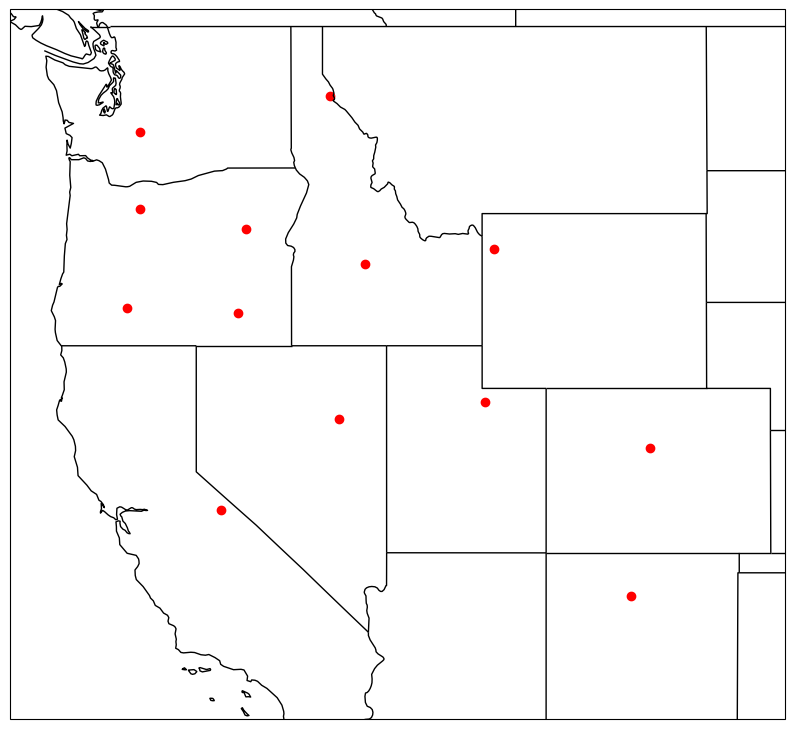

In [129]:
sites = gpd.read_file('../data_sandbox/swe_errors/snotel/fig4_sites.csv')
sites['geometry'] = gpd.points_from_xy(sites['lon'], sites['lat'], crs='epsg:4326')
sites = gpd.GeoDataFrame(sites).to_crs('epsg:3857')

countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.epsg(3857))
ax.coastlines()
# ax.
ax.add_feature(countries)
ax.add_feature(states_provinces)
minx, miny, maxx, maxy = sites.total_bounds
minx *= 1.03
maxx *= 0.96
miny *= 0.9
maxy *= 1.05
ax.set_extent((minx, maxx, miny, maxy), crs=ccrs.epsg(3857))

sites['geometry'].plot(ax=ax, color='r')


<BarContainer object of 3 artists>

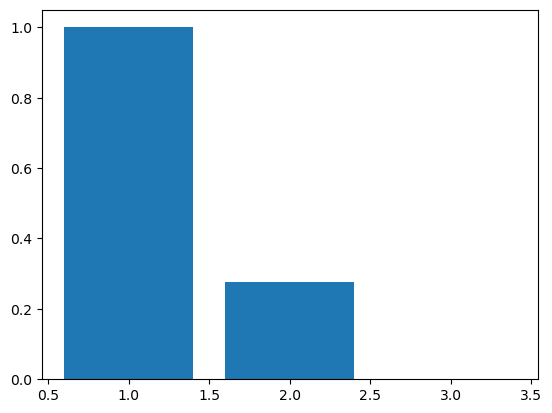

In [127]:
rel_error = pd.DataFrame(sites['median_peak_swe'] / sites['median_peak_swe'])
rel_error['soil_error'] = sites['soil_error'] / sites['median_peak_swe']
rel_error['veg_error'] = sites['veg_error'] / sites['median_peak_swe']

fig, ax = plt.subplots()
ax.bar([1,2,3], rel_error.loc[12])

In [126]:
rel_error

0                                                           1.0
1                                                           1.0
2                                                           1.0
3                                                           1.0
4                                                           1.0
5                                                           1.0
6                                                           1.0
7                                                           1.0
8                                                           1.0
9                                                           1.0
10                                                          1.0
11                                                          1.0
12                                                          1.0
soil_error    0     0.025407
1     0.103637
2     0.051172
3...
veg_error     0     0.002518
1     0.000075
2     0.000000
3...
Name: median_peak_swe, dtype: object

In [122]:
sites['median_peak_swe']

0     2.09042
1     0.37338
2     1.10236
3     0.42926
4     0.35306
5     0.45720
6     0.54610
7     0.51308
8     0.54610
9     0.83820
10    0.66294
11    0.30480
12    0.18796
Name: median_peak_swe, dtype: float64